とあるアニメのタイトルを入力した際に、そのアニメと距離が近い（類似性が高い）アニメのタイトルをオススメとして返してくれるモデルを実装します

データセットは下記

https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [2]:
# ライブラリのimport
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
# CSVファイルの読み込み
ratings = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

In [5]:
# データの確認
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
# データフレームをmembers順に並び替え、10行だけ表示
anime.sort_values('members', ascending=False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [9]:
# 基本統計量の確認
round(anime.describe(),2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


In [10]:
round(ratings.describe(), 2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


# ヒストグラムの表示
レーティングのヒストグラムを確認してみると、「-1」（レーティング無し）と「7以上」の値がほとんどを占めていることがわかる。

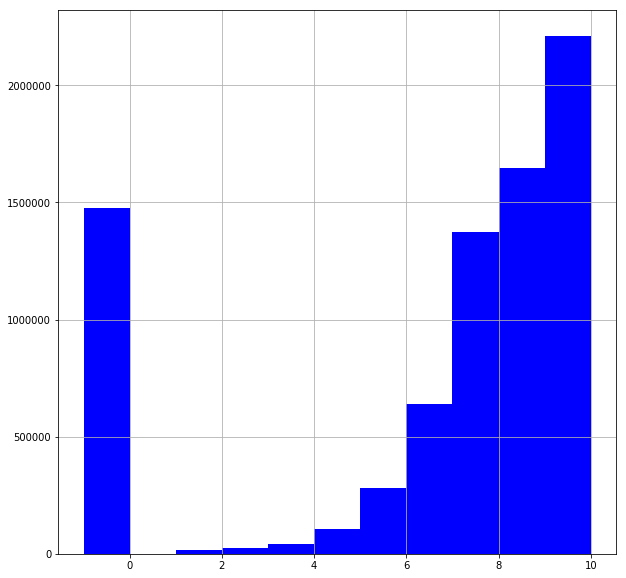

In [20]:
#import matplotlib.pyplot as plt
%matplotlib inline
# ratingのヒストグラムを作成
# figsizeはグラフのサイズを指定するときに使うパラメータ（幅、高さ）。単位はインチ。
ratings['rating'].hist(bins=11, figsize=(10,10), color='blue')

# アニメデータの前処理
これから構築するレコメンドエンジンの質を向上する為、 members （当該のアニメのグループに所属しているユーザー数）が5,000以下のデータを足切りをしましょう。足切りすることにより、これから構築するレコメンド機能が、メンバー数が少ないアニメ（つまり比較的人気の低いアニメ）をオススメしないようになります。

In [21]:
# データの切り分け
anime = anime[anime['members'] > 5000]

In [23]:
round(anime.describe(),2)

,anime_id,rating,members
count,3987.00,3913.00,3987.00
mean,11053.77,7.28,53541.94
std,10818.26,0.68,86039.78
min,1.00,2.00,5001.00
25%,1531.50,6.88,10001.00
50%,7322.00,7.32,21648.00
75%,18678.00,7.72,57647.50
max,34465.00,9.37,1013917.00


In [24]:
# 欠損値の確認
anime.isnull().sum()

anime_id     0
name         0
genre        3
type         5
episodes     0
rating      74
members      0
dtype: int64

In [31]:
# 欠損値の割合、値のバリエーションを調べる
def null_search(df):
    for i in df.columns:
        print("■■■  " + i )
        print("NULL数:" + str(df[i].isnull().sum() )+
                 "　　　　NULL率:" + str((df[i].isnull().sum()/len(df)).round(3)) +
                 "    データの種類数:" + str(df[i].value_counts().count()))

In [32]:
null_search(anime)

■■■  anime_id
NULL数:0　　　　NULL率:0.0    データの種類数:3987
■■■  name
NULL数:0　　　　NULL率:0.0    データの種類数:3987
■■■  genre
NULL数:3　　　　NULL率:0.001    データの種類数:1936
■■■  type
NULL数:5　　　　NULL率:0.001    データの種類数:6
■■■  episodes
NULL数:0　　　　NULL率:0.0    データの種類数:123
■■■  rating
NULL数:74　　　　NULL率:0.019    データの種類数:373
■■■  members
NULL数:0　　　　NULL率:0.0    データの種類数:3812


In [33]:
# 欠損値に各カラムの平均値を設定する
anime = anime.fillna(anime.mean())

In [34]:
# 再度欠損値の確認
anime.isnull().sum()

anime_id    0
name        0
genre       3
type        5
episodes    0
rating      0
members     0
dtype: int64

平均値は数値項目しか設定されないため、文字列データは削除することとする

In [37]:
# 欠損データをdropna()でデータセットから取り除く
anime = anime.dropna()

In [38]:
# 再度欠損値の確認
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [41]:
# 統計情報
# 8つのデータが削除されていることがわかる
round(anime.describe(),2)

,anime_id,rating,members
count,3979.00,3979.00,3979.00
mean,11009.35,7.28,53607.94
std,10783.51,0.67,86110.54
min,1.00,2.00,5001.00
25%,1528.50,6.88,10001.00
50%,7222.00,7.31,21706.00
75%,18570.00,7.71,57657.00
max,34465.00,9.37,1013917.00


# レーティングデータの前処理
「-1（見たけど評価しなかった）」が含まれています。まずは、この「-1」のデータを取り除きましょう。

In [42]:
# raitingの値が0以上のみ残す
ratings = ratings[ratings.rating >= 0]

In [45]:
# ご覧の通り先ほどはレーティングの最小値（min）が-1とありましたが、
# データの前処理を行いましたので「1」へと変わっているのが確認できます。
round(ratings.describe(), 2)

,user_id,anime_id,rating
count,6337241.00,6337241.00,6337241.00
mean,36747.91,8902.87,7.81
std,21013.40,8882.00,1.57
min,1.00,1.00,1.00
25%,18984.00,1239.00,7.00
50%,36815.00,6213.00,8.00
75%,54873.00,14075.00,9.00
max,73516.00,34475.00,10.00


# データのマージ
データを「 anime_id 」を軸にして、「user_id」毎に切り分けてマージさせましょう。

In [46]:
# animeとratingsの2つのデータフレームをマージさせる
# suffixesは同一のカラム名が存在した場合に、後ろに文字列を追加して区別します。 (デフォルトは ‘_x’, ‘_y’)
mergeddf = ratings.merge(anime, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])

# 合体したデータフレームの最初の5行を表示
mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [47]:
# 統計量を表示
round(mergeddf.describe(), 2)

,user_id,anime_id,rating_user,rating,members
count,6147491.00,6147491.00,6147491.00,6147491.00,6147491.00
mean,36705.78,8952.14,7.84,7.71,190187.19
std,21025.42,8905.06,1.55,0.64,191144.79
min,1.00,1.00,1.00,2.00,5001.00
25%,18949.00,1195.00,7.00,7.33,51844.00
50%,36688.00,6347.00,8.00,7.72,123217.00
75%,54873.00,14227.00,9.00,8.17,265791.00
max,73516.00,34240.00,10.00,9.37,1013917.00


今回のレコメンド機能に使うデータは「 user_id 」「 name 」「 rating_user 」の3項目のみです。データの前処理の最後の項目として、使わないデータ項目の削除と重複データのカットを行いましょう。

In [48]:
# 不必要な項目と重複項目を削除
mergeddf = mergeddf[['user_id','name','rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id','name'])

# head()で最初の5行を表示
mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


 name （アニメのタイトル名）がデータフレームのインデックスに、 user_id をカラムとして、ピボットさせましょう。文字で見ると、いまいち分かりにくいかも知れませんが、実際にデータフレームを処理して見てみると分かるかと思います。

またピボットの処理と併せて、ユーザーが評価していないアニメに関しては  fillna(0) で「0」の値を入れてあげましょう。

In [61]:
# データフレームのピボット
anime_pivot = mergeddf.pivot(index= 'name',columns='user_id',values='rating_user').fillna(0)

# メモリ、計算時間ともに大幅な節約をするために、csr_matrixで疎行列を定義
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [62]:
# anime_pivotの最初の10行を表示
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy: Parody Mode,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Liminality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
anime_pivot.shape

(3832, 69556)

In [64]:
anime_pivot_sparse.shape

(3832, 69556)

# k近傍法（k-nearest neighbors）でレコメンド機能を構築

今回の例で考えると、とあるアニメのタイトルを入力した際に、そのアニメのneighbors（ご近所さん）を探して、距離が近い（類似性が高い）アニメのタイトルをオススメとして返してくれます。

In [65]:
# Scikit-learnのライブラリを利用します
# n_neiborsやalgorithm、metricなど重要なアーギュメントを設定しています
knn = NearestNeighbors(n_neighbors=9,algorithm= 'brute', metric= 'cosine')
# 前処理したデータセットでモデルを訓練
model_knn = knn.fit(anime_pivot_sparse)

# レコメンド機能の確認

In [66]:
# データセットのタイトルをキーワードで検索できる関数
def searchanime(string):
    print(anime_pivot[anime_pivot.index.str.contains(string)].index[0:])

In [71]:
searchanime('Code')

Index(['Code Geass: Boukoku no Akito 1 - Yokuryuu wa Maiorita',
       'Code Geass: Boukoku no Akito 2 - Hikisakareshi Yokuryuu',
       'Code Geass: Boukoku no Akito 2 - Hikisakareshi Yokuryuu Picture Drama',
       'Code Geass: Boukoku no Akito 3 - Kagayaku Mono Ten yori Otsu',
       'Code Geass: Boukoku no Akito 4 - Nikushimi no Kioku Kara',
       'Code Geass: Boukoku no Akito Final - Itoshiki Monotachi e',
       'Code Geass: Hangyaku no Lelouch',
       'Code Geass: Hangyaku no Lelouch - Kiseki no Birthday Picture Drama',
       'Code Geass: Hangyaku no Lelouch - Kiseki no Birthday Picture Drama Flash Special',
       'Code Geass: Hangyaku no Lelouch Picture Drama',
       'Code Geass: Hangyaku no Lelouch R2',
       'Code Geass: Hangyaku no Lelouch R2 Picture Drama',
       'Code Geass: Hangyaku no Lelouch R2 Special Edition Zero Requiem',
       'Code Geass: Hangyaku no Lelouch R2: Flash Specials',
       'Code Geass: Hangyaku no Lelouch Recaps',
       'Code Geass: Hangyaku n

In [72]:
# 「コードギアス」に対してのオススメのアニメ10個
Anime = 'Code Geass: Hangyaku no Lelouch'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Code Geass: Hangyaku no Lelouch:

1: Code Geass: Hangyaku no Lelouch R2 with distance: 0.08030135228084823
2: Death Note with distance: 0.3801604472543014
3: Fullmetal Alchemist: Brotherhood with distance: 0.4467318707575568
4: Tengen Toppa Gurren Lagann with distance: 0.46375190740042627
5: Steins;Gate with distance: 0.4669313680066317
6: Fullmetal Alchemist with distance: 0.47450783746266967
7: Darker than Black: Kuro no Keiyakusha with distance: 0.47840730954601096
8: Elfen Lied with distance: 0.4800910095984763
9: Angel Beats! with distance: 0.482951844396871
10: Shingeki no Kyojin with distance: 0.499114415996728
